#### Add Frame Number

In [ ]:
import os
import cv2
import sys
# import matplotlib.pyplot as plt


In [ ]:
def add_frame_number(video_path):
    cap = cv2.VideoCapture(video_path)
    fps = cap.get(cv2.CAP_PROP_FPS)
    width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))   # float `width`
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    
    video_writer = cv2.VideoWriter(video_path.replace("Better","output"),
                                    cv2.VideoWriter_fourcc(*'MP4V'), fps, (width,height))
    c=0
    font = cv2.FONT_HERSHEY_SIMPLEX
    thickness=2
    fontScale = 1
    color = (255, 0, 0)
    org = (960, 1070)
    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret == True:
            frame = cv2.putText(frame,"Frame Number:"+ str(c), org, font, 
                   fontScale, color, thickness, cv2.LINE_AA)
            video_writer.write(frame)
            c+=1
#             if c>10:
#                 break
        else: 
            break
    cap.release()
    video_writer.release()

In [ ]:
!mkdir output

In [ ]:
for folder in os.listdir("Videos/"):
    print("FOLDER ", folder)
    for subfolder in os.listdir("Videos/" + folder ):
        for subsubfolder in os.listdir("Videos/" + folder + "/" + subfolder ):
            for file in os.listdir("Videos/" + folder + "/" + subfolder +  "/" + subsubfolder ):
                if ".mp4" in file:
                    print(folder ,"====", subfolder, "===", subsubfolder, "===", file)
                    folder_path=os.path.join("output", folder, subfolder, subsubfolder)
                    os.makedirs(folder_path, exist_ok = True)
                    video_path = os.path.join("Videos", folder, subfolder, subsubfolder, file)
#                     print(cv2.VideoCapture(video_path).isOpened())
                    add_frame_number(video_path)
        

In [ ]:
for file in os.listdir("Better/"):
    if ".mp4" in file:
#         print(folder ,"====", subfolder, "===", subsubfolder, "===", file)
#         folder_path=os.path.join("output", folder, subfolder, subsubfolder)
#         os.makedirs(folder_path, exist_ok = True)
        video_path = os.path.join("Better", file)
        add_frame_number(video_path)     

In [ ]:
for folder in os.listdir("Videos/"):
    print("FOLDER ", folder)
    for subfolder in os.listdir("Videos/" + folder ):
        for subsubfolder in os.listdir("Videos/" + folder + "/" + subfolder ):
            for file in os.listdir("Videos/" + folder + "/" + subfolder +  "/" + subsubfolder ):
                if ".mp4" in file:
                    print(folder ,"====", subfolder, "===", subsubfolder, "===", file)
                    folder_path=os.path.join("output", folder, subfolder, subsubfolder)
                    os.makedirs(folder_path, exist_ok = True)
                    video_path = os.path.join("Videos", folder, subfolder, subsubfolder, file)
#                     print(cv2.VideoCapture(video_path).isOpened())
                    add_frame_number(video_path)
        

#### Opencv Mask

In [ ]:
%cd "D:/Stupa/V3 Data/Videos/tablemasks"

In [ ]:
import os
import sys
import cv2
import json
import numpy as np
import pandas as pd
from shapely import geometry
import matplotlib.pyplot as plt

In [ ]:
os.listdir(".")

In [ ]:
def get_coords(name):
    f = open(name)
    data = json.load(f)
#     res = [(sub[1], sub[0]) for sub in data["coordinates"]]
    return np.array([data["coordinates"]])

In [ ]:
names  = os.listdir(".")

In [ ]:
for name in names:
    points = get_coords(name)
    mask   = np.zeros((1080, 1920))
    res    = cv2.fillPoly(mask, pts=[points], color=(255, 0, 0))
    
    cv2.imwrite(name.split(".")[0]+".jpg", res)

In [ ]:
plt.imshow(mask)

## Tool

In [ ]:
%cd "D:/Stupa/V3 Data"

In [ ]:
import os
import sys
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
class Tool:
    def __init__(self, SET_NUMBER=1, VIDEO_PATH=None):
        self.clip_videos    = True
        self.plot_pitches   = True
        self.plot_shot      = True
        self.plot_service   = True
    
        self.data           = pd.read_csv("Data Annotation timeline - Dang Qiu vs Yuan Licen .csv")
        self.data           = self.data.replace('?', np.NaN)
        self.data           = self.data.replace('no', np.NaN)

        self.SET_NUMBER = SET_NUMBER
        self.data           = self.data[self.data["Set Number"] == str(self.SET_NUMBER)]
        VIDEO_PATH          = "D:/Stupa/V3 Data/Videos/"
        VIDEO_PATH          = os.path.join(VIDEO_PATH , self.data.iloc[0]["Location"] , self.data.iloc[0]["Match Name"].strip())
        
        VIDEO_PATH      = os.path.join(VIDEO_PATH , "Set" + self.data.iloc[0]["Set Number"].strip() )
        self.VIDEO_PATH = os.path.join(VIDEO_PATH ,  self.data.iloc[0]["Match Name"] + "set" +  self.data.iloc[0]["Set Number"].strip() + ".mp4")
        self.FRAME_NUMBER = 0
        self.CAP          = cv2.VideoCapture(self.VIDEO_PATH)
        self.output_video = cv2.VideoWriter('result.mp4',
                                 cv2.VideoWriter_fourcc(*'MP4V'),
                                 15,  (1920, 1080))
        
        if self.CAP.isOpened():
            print("Video Opened")
        else:
            print("issue in Video loading ", self.VIDEO_PATH)
        
        #clipping Data
        if self.clip_videos == True:
            self.data["Frame Number Start"] = pd.to_numeric(self.data["Frame Number Start"])
            self.data["Frame Number End"]   = pd.to_numeric(self.data["Frame Number End"])
            self.unskipped_frames           = self.data.loc[self.data['Angel change'].notnull(), ["Frame Number Start", 'Frame Number End']]
            self.skip_index                 = 0
            self.start_skip                 = list(self.unskipped_frames["Frame Number Start"].values)
            self.end_skip                   = list(self.unskipped_frames["Frame Number End"].values)

        if self.plot_pitches:
            self.pitches_frames =  list(self.data.loc[self.data['Pitch'].notnull(), ["Frame Number Start"]]["Frame Number Start"].values)
            
        if self.plot_shot:
            
            self.shot_frames =  self.data.loc[self.data['ShotType'].notnull(), ["ShotType","Frame Number Start","Frame Number End"]]
            self.shot_index       = 0
            self.shot_list        = list(self.shot_frames["ShotType"].values)
            self.start_shot       = list(self.shot_frames["Frame Number Start"].values)
            self.end_shot         = list(self.shot_frames["Frame Number End"].values)
            
        if self.plot_service:
            self.service_frames  =   self.data.loc[self.data['Service'].notnull(), ["Frame Number Start","Frame Number End"]]
            self.start_service   =   list(self.service_frames["Frame Number Start"].values)
            self.end_service     =   list(self.service_frames["Frame Number End"].values)
            self.service_index   =   0
        
    def videos_clip(self):
        if self.skip_index < len(self.start_skip):
            if self.FRAME_NUMBER == self.start_skip[self.skip_index]:
                    for _ in range(self.end_skip[self.skip_index] - self.start_skip[self.skip_index]):
                        _, _ = self.CAP.read()
                        self.FRAME_NUMBER += 1
                    print("Frame Skipped ", "**********************" ,self.skip_index,self.end_skip[self.skip_index], self.start_skip[self.skip_index]  )
                    self.skip_index += 1
        else:
            pass
    
    def pitches_plot(self):
        status = False
        if self.FRAME_NUMBER in self.pitches_frames:
            status = True
        self.frame = cv2.putText(self.frame,"Pitch : " + str(status), (1600, 140),  cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
    def shot_plot(self):
        
        if self.shot_index < len(self.shot_list):
            if self.FRAME_NUMBER >= self.start_shot[self.shot_index] and self.FRAME_NUMBER < self.end_shot[self.shot_index] :
                SHOT = self.shot_list[self.shot_index]
                self.frame = cv2.putText(self.frame,"SHOT : " + str(SHOT), (1600, 180),  cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            elif self.FRAME_NUMBER == self.end_shot[self.shot_index]:
                SHOT = self.shot_list[self.shot_index]
                self.frame = cv2.putText(self.frame,"SHOT : " + str(SHOT), (1600, 180),  cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
                self.shot_index += 1

    def service_plot(self):
        
        if self.service_index < len(self.service_frames):
            if self.FRAME_NUMBER >= self.start_service[self.service_index] and self.FRAME_NUMBER < self.end_service[self.service_index] :
                self.frame = cv2.putText(self.frame,"Service", (1600, 220),  cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
            elif self.FRAME_NUMBER == self.end_service[self.service_index]:
                self.frame = cv2.putText(self.frame,"Service", (1600, 220),  cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
                self.service_index += 1
        
    def frame_count(self):
        self.frame = cv2.putText(self.frame,"Frame Number: "+ str(self.FRAME_NUMBER), (1600, 100),  cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2, cv2.LINE_AA)
        
    def __call__(self):
        self.frame_count()
        if self.clip_videos:
            self.videos_clip()      
        if self.plot_pitches:
            self.pitches_plot()
        if self.plot_shot:
            self.shot_plot()
        if self.plot_service:
            self.service_plot()
    
    def run(self):
        while True:
            ret, self.frame = self.CAP.read()
            if ret == False:
                break
            self.FRAME_NUMBER += 1
            self()
            self.output_video.write(self.frame)
        self.output_video.release()

In [ ]:
tool = Tool()

In [ ]:
tool.run()

In [ ]:
# import json
# game = json.load("C:/Users/rlrah/Downloads/game.json")
# f = open("C:/Users/rlrah/Downloads/game.json")
# game = json.load(f)
# game.keys()
# f = open("C:/Users/rlrah/Downloads/point.json")
# point = json.load(f)
# point.keys()

### Mask Data Generator

In [1]:
# %cd "D:/Stupa/V3 Data"
%cd "../new/yolov7-segmentation/"

C:\sTUPA\new\yolov7-segmentation


In [2]:
pwd

'C:\\sTUPA\\new\\yolov7-segmentation'

In [3]:
import os
import sys
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [4]:
os.listdir(".")

['.git',
 '.github',
 'data',
 'export.py',
 'football1.mp4',
 'LICENSE',
 'masks',
 'models',
 'README.md',
 'requirements.txt',
 'scripts',
 'segment',
 'train.py',
 'utils',
 'val.py',
 'Yolov7 Segmentation.ipynb',
 'yolov7-seg.pt',
 '__pycache__']

In [5]:
HUMAN_MASKS  = "masks/"
OPENCV_MASKS = "Videos/tablemasks/"

In [8]:
for _ in os.listdir(HUMAN_MASKS):
    MASK = np.load(os.path.join(HUMAN_MASKS, _))
    print(_)
    break

1.npy


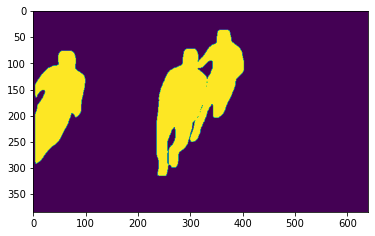

In [9]:
plt.imshow(MASK)

In [10]:
MASK.shape

(384, 640)